In [ ]:
!pip install contractions

In [ ]:
!pip install --upgrade tensorflow tensorflow-hub

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
import tensorflow_hub as hub

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Load Data and EDA

In [49]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [50]:
train = pd.read_csv('/content/drive/My Drive/code/Tweet/train.csv', encoding='latin-1')
test = pd.read_csv('/content/drive/My Drive/code/Tweet/test.csv', encoding='latin-1')

In [51]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [53]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

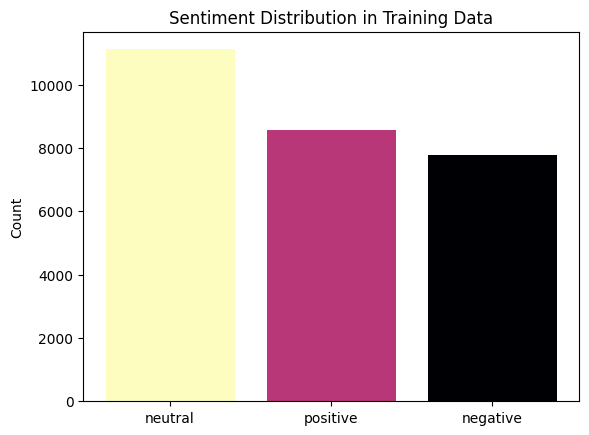

In [54]:
sentiment_counts = train['sentiment'].value_counts()

ranks = np.argsort(np.argsort(sentiment_counts.values))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.ylabel("Count")
plt.title("Sentiment Distribution in Training Data")
plt.show()

Use only text and sentiment columns

In [55]:
col = ['text', 'sentiment']

train_df = train[col]
test_df = test[col]

## Prepare Sentiment Labels

In [56]:
sentiment_to_index = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
  }

train_df.loc[:, 'sentiment'] = train_df['sentiment'].map(sentiment_to_index)
test_df.loc[:, 'sentiment'] = test_df['sentiment'].map(sentiment_to_index)

In [57]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Prepare Text Data

### Adjust Words based on REGEX

In [58]:
def remove_special_character(text):
    text=re.sub('<.*?>', ' ', text)
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    text = re.sub('`', "'",  text)
    # Keep apostrophes only if inside words (like "I'm", "don't")
    text = re.sub(r"[^\w\s']", '', text)
    return text

In [59]:
import contractions

# couldn't -> could not
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [60]:
train_df.loc[:, 'text'] = train_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)
test_df.loc[:, 'text'] = test_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)

In [61]:
train_df.head()

,text,sentiment
0,i would have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why could not they put them on the re...,0


### Tokenize

In [62]:
train_tokens = []

for _, row in train_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    train_tokens.append([row["sentiment"], tokens])

In [63]:
train_tokens[:3]

[[1, ['i', 'would', 'have', 'responded', 'if', 'i', 'were', 'going']],
 [0,
  ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego']],
 [0, ['my', 'boss', 'is', 'bullying', 'me']]]

In [64]:
test_tokens = []

for _, row in test_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    test_tokens.append([row["sentiment"], tokens])

In [65]:
test_tokens[:3]

[[1, ['last', 'session', 'of', 'the', 'day']],
 [2,
  ['shanghai',
   'is',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscrapers',
   'galore',
   'good',
   'tweeps',
   'in',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession',
   'hit',
   'veronique',
   'branquinho',
   'she',
   'has',
   'to',
   'quit',
   'her',
   'company',
   'such',
   'a',
   'shame']]]

### Remove stop words and Apply Lemmatizer

In [66]:
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words("english"))

def preprocess_tokens(tokens):
    processed_tokens = []
    for token_list in tokens:
        label, words = token_list[0], token_list[1]
        filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords

        lemmatized_words = []
        for doc in nlp.pipe(filtered_words, disable=["parser", "ner"]):
            lemmatized_words.append(doc[0].lemma_)

        processed_tokens.append([label, lemmatized_words])
    return processed_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
train_processed = preprocess_tokens(train_tokens)
train_processed[:5]

[[1, ['would', 'respond', 'go']],
 [0, ['sooo', 'sad', 'miss', 'san', 'diego']],
 [0, ['boss', 'bully']],
 [0, ['interview', 'leave', 'alone']],
 [0, ['son', 'could', 'put', 'release', 'already', 'buy']]]

In [68]:
test_processed = preprocess_tokens(test_tokens)
test_processed[:5]

[[1, ['last', 'session', 'day']],
 [2,
  ['shanghai',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscraper',
   'galore',
   'good',
   'tweep',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession', 'hit', 'veronique', 'branquinho', 'quit', 'company', 'shame']],
 [2, ['happy', 'birthday']],
 [2, ['like']]]

## Create Vocab and Index Dictitonary

In [69]:
from collections import Counter

word_counts = Counter(word for _, sentence in train_processed for word in sentence)

# Sort words by frequency
vocab_list = [word for word, _ in word_counts.most_common()]

# Convert to dictionary with indices (starting from 2 for special tokens)
vocab = {"_PAD": 0, "_UNK": 1}
vocab.update({word: idx for idx, word in enumerate(vocab_list, start=2)})

print(list(vocab.items())[:10])

[('_PAD', 0), ('_UNK', 1), ('go', 2), ('get', 3), ('day', 4), ("'", 5), ('good', 6), ('work', 7), ('like', 8), ('well', 9)]


In [70]:
vocab_size = len(vocab)
print(f'Vocab size: {vocab_size}')

Vocab size: 22807


### Encode text

In [80]:
train_encoded = [[label, [vocab[word] if word in vocab else 1 for word in sentence]]
                for label, sentence in train_processed]

test_encoded = [[label, [vocab[word] if word in vocab else 1 for word in sentence]]
                for label, sentence in test_processed]

In [81]:
train_encoded[:10]

[[1, [29, 1152, 2]],
 [0, [295, 61, 23, 1072, 1822]],
 [0, [999, 3616]],
 [0, [761, 69, 365]],
 [0, [576, 55, 181, 751, 129, 147]],
 [1, [8194, 1599, 9, 3149, 1600, 1073]],
 [2, [39, 8195, 183, 53, 455, 5557]],
 [1, [420, 400]],
 [1, []],
 [2, [1700, 170, 483, 106, 398, 696]]]

## Shorten or Pad sequences

In [82]:
train_label, train_text = zip(*train_encoded)
test_label, test_text = zip(*test_encoded)

train_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, maxlen=100, padding='post')
test_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, maxlen=100, padding='post')

## Create Dataset

#### Training and Validation

In [83]:
train_text = np.array(train_text, dtype=np.int32)
train_label = np.array(train_label, dtype=np.int32)

In [84]:
train_val_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_label))
train_val_dataset = train_val_dataset.shuffle(len(train_text), seed=42) # Shuffle the entire dataset

train_ratio = 0.9
total_size = len(train_text)
train_size = int(train_ratio * total_size)

train_dataset = train_val_dataset.take(train_size)
val_dataset = train_val_dataset.skip(train_size)

train_dataset = train_dataset.map(lambda x, y: (tf.squeeze(x), y)).batch(100).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (tf.squeeze(x), y)).batch(1).prefetch(tf.data.AUTOTUNE)

#### Testing

In [86]:
test_text = np.array(test_text, dtype=np.int32)
test_label = np.array(test_label, dtype=np.int32)

In [87]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_label))
test_dataset = test_dataset.shuffle(len(test_text)).batch(1)

## Data Prediction

### Initialize Model

In [110]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),

    # First dense block
    tf.keras.layers.Dense(256),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Activation(tf.nn.gelu),
    tf.keras.layers.Dropout(0.4),

    # Residual connection
    tf.keras.layers.Dense(128),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Activation(tf.nn.gelu),
    tf.keras.layers.Dropout(0.3),

    # Pooling layer
    tf.keras.layers.GlobalAveragePooling1D(),

    # Second dense block
    tf.keras.layers.Dense(64),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Activation(tf.nn.gelu),
    tf.keras.layers.Dropout(0.2),

    # Third dense block
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation(tf.nn.gelu),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

In [111]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3, first_decay_steps=1000, t_mul=2.0, m_mul=0.9
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [112]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 87s 334ms/step - accuracy: 0.3843 - loss: 1.1073 - val_accuracy: 0.4647 - val_loss: 0.9782
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 139s 324ms/step - accuracy: 0.5844 - loss: 0.8531 - val_accuracy: 0.7391 - val_loss: 0.6509
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 335ms/step - accuracy: 0.7591 - loss: 0.5970 - val_accuracy: 0.8322 - val_loss: 0.4501
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 335ms/step - accuracy: 0.8137 - loss: 0.4870 - val_accuracy: 0.8483 - val_loss: 0.4276
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 139s 323ms/step - accuracy: 0.8004 - loss: 0.5137 - val_accuracy: 0.8231 - val_loss: 0.4401
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 333ms/step - accuracy: 0.8271 - loss: 0.4590 - val_accuracy: 0.8828 - val_loss: 0.3342
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 142s 333ms/step - accuracy: 0.8512 - loss: 0.4038 - val_accuracy: 0.8846 - val_loss: 0.3208
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 140s 325ms/step - accuracy: 0.8670 - los

In [113]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 128)            │       2,919,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 100, 256)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_21               │ (None, 100, 256)            │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 100, 128)            │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_22               │ (None, 100, 128)            │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_23               │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,989,642 (34.29 MB)

 Trainable params: 2,996,547 (11.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,993,095 (22.86 MB)

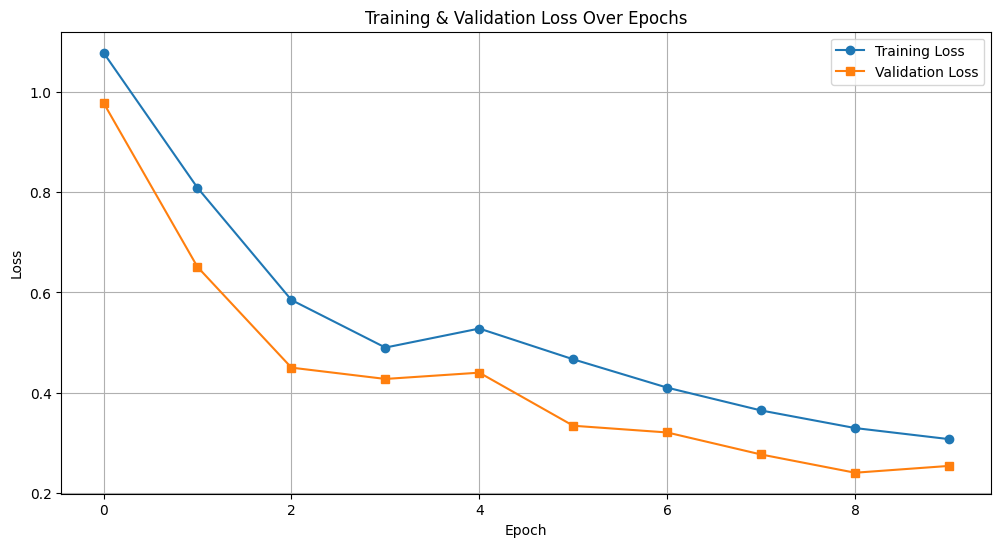

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training & Validation Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [115]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

3534/3534 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6671 - loss: 1.0510
Test Loss: 1.0410
Test Accuracy: 0.6655


In [116]:
x_test, y_true = zip(*[data for data in test_dataset]) # Extract from dataset
x_test = np.squeeze(x_test)
x_test = np.array(x_test)
y_true = np.array(y_true)

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1) # Convert to class labels

print(classification_report(y_true, y_pred))

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
              precision    recall  f1-score   support

           0       0.68      0.64      0.65      1001
           1       0.63      0.65      0.64      1430
           2       0.71      0.71      0.71      1103

    accuracy                           0.67      3534
   macro avg       0.67      0.67      0.67      3534
weighted avg       0.67      0.67      0.67      3534



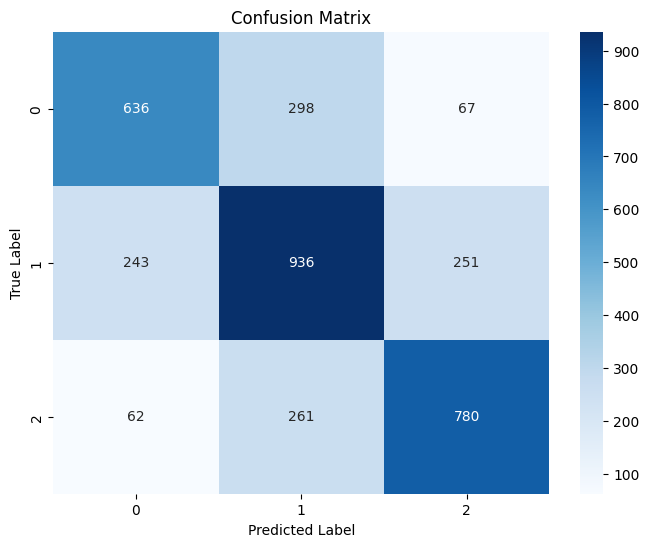

In [117]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()